# `tf.train.Saver`

* code `02_mnist_cnn_with_slim.ipynb`를 바탕으로 모델 save 및 load (restore)를 해보자.
* [`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) 참고

### Import modules

In [1]:
"""A very simple MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

np.random.seed(219)
tf.set_random_seed(219)

Instructions for updating:
Use the retry module or similar alternatives.


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

N = 50
train_data = train_data[:N]
train_labels = train_labels[:N]

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [3]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [4]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

### Create the model

In [5]:
def cnn_model_fn(x):
  """Model function for CNN.
  Args:
    x: input images
    mode: boolean whether trainig mode or test mode
    
  Returns:
    logits: unnormalized score funtion
  """
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')
                      

  # Pooling Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
  
  # Convolutional Layer #2
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  # 여기를 직접 채워 넣으시면 됩니다.
  pool2_flat = slim.flatten(pool2, scope='flatten')
  
  # Fully connected Layer
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')

  # Add dropout operation; 0.6 probability that element will be kept
  is_training = tf.placeholder(tf.bool)
  # 여기를 직접 채워 넣으시면 됩니다.
  fc1_drop = fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  # 여기를 직접 채워 넣으시면 됩니다.
  logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')
  
  return logits, is_training, x_image

### Build the model

In [6]:
logits, is_training, x_image = cnn_model_fn(x)

### Define loss and optimizer

In [7]:
# 여기를 직접 채워 넣으시면 됩니다.
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### `tf.train.Saver`

```python
tf.train.Saver.save(sess, save_path, global_step=None...)
tf.train.Saver.restore(sess, save_path)
```

#### `tf.train.Saver.restore`

In [8]:
# Create a saver object for restoring
saver = tf.train.Saver()

In [9]:
checkpoints_dir = '/checkpoint/model/'

In [10]:
sess = tf.Session(config=sess_config)

# read the lastest model checkpoint
model_ckpt = tf.train.latest_checkpoint(checkpoints_dir)
print(model_ckpt)
# use saver object to load variables from the saved model
saver.restore(sess, model_ckpt)

/checkpoint/model/
INFO:tensorflow:Restoring parameters from /checkpoint/model/


### Test trained model
* test accuracy: 0.5844

In [11]:
# test_iterator
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())
sess.run(test_iterator.initializer)

In [12]:
accuracy, acc_op = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, 1), name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, is_training: False})
print("test accuracy:", sess.run(accuracy, feed_dict={handle: test_handle, is_training: False}))

test accuracy: 0.6346


### Print results

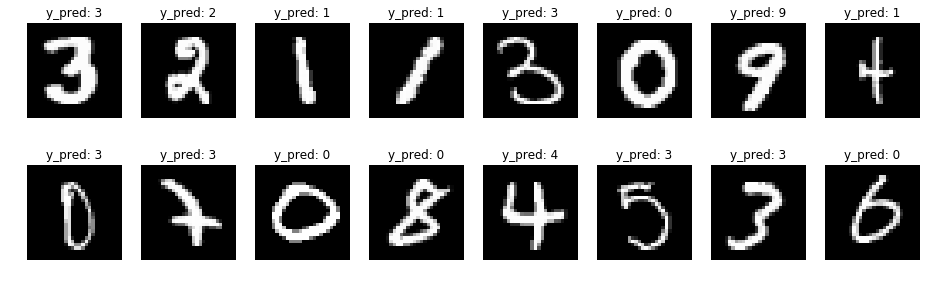

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index]
y_pred = sess.run(logits, feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  p.set_title("y_pred: {}".format(np.argmax(py)))
  p.imshow(px.reshape(28, 28), cmap='gray')
  p.axis('off')